In [1]:
#! pip install lightgbm

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier

import lightgbm as lgb
import pickle
import base64

In [3]:
# Reduire la taille des données
def reduce_mem_usage(df):
   
    start_mem = df.memory_usage().sum() / 1024**2
    print('Taille du Dataframe avant traitement {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Taille du Dataframe après traitement: {:.2f} MB'.format(end_mem))
    print('Réduction de {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
train = pd.read_csv("Train.csv")

In [5]:
train = reduce_mem_usage(train)

Taille du Dataframe avant traitement 117.30 MB
Taille du Dataframe après traitement: 21.41 MB
Réduction de 81.7%


In [6]:
train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,credSURrevenu,annuitySURrevenu
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Working,Secondary / secondary special,Single / not married,House / apartment,0.018799,-9461,-637.0,1,1,0,1,1,0,1.0,Business Entity Type 3,0.262939,0.139404,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.007812,0.121948
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,State servant,Higher education,Married,House / apartment,0.003542,-16765,-1188.0,1,1,0,1,1,0,2.0,School,0.622070,0.510742,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.789062,0.132202
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Working,Secondary / secondary special,Single / not married,House / apartment,0.010033,-19046,-225.0,1,1,1,1,1,0,1.0,Government,0.556152,0.729492,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.000000,0.099976
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008018,-19005,-3040.0,1,1,0,1,0,0,2.0,Business Entity Type 3,0.650391,0.510742,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.316406,0.219849
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Working,Secondary / secondary special,Single / not married,House / apartment,0.028656,-19932,-3038.0,1,1,0,1,0,0,1.0,Religion,0.322754,0.510742,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,4.222656,0.179932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307490,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,225000.0,Working,Secondary / secondary special,Separated,With parents,0.032562,-9327,-236.0,1,1,0,1,0,0,1.0,Services,0.681641,0.510742,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.617188,0.174927
307491,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,225000.0,Pensioner,Secondary / secondary special,Widow,House / apartment,0.025162,-20775,-2384.0,1,0,0,1,1,0,1.0,XNA,0.115967,0.510742,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.744141,0.166748
307492,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,585000.0,Working,Higher education,Separated,House / apartment,0.005001,-14966,-7920.0,1,1,0,1,0,1,1.0,School,0.535645,0.218872,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.429688,0.195923
307493,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,319500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,0.005314,-11961,-4784.0,1,1,0,1,0,0,2.0,Business Entity Type 1,0.514160,0.661133,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.164062,0.118164


In [7]:
modelisation = train.drop(['SK_ID_CURR', 'TARGET', 'AMT_GOODS_PRICE'], axis=1)
model_num = modelisation.select_dtypes(exclude=['object', 'category'])
model_cat = modelisation.select_dtypes(include=['object', 'category'])
model_onhot = pd.get_dummies(model_cat, drop_first=True)

model = pd.concat([train['SK_ID_CURR'],model_num, model_onhot], axis=1)

In [8]:
X = model
y = train['TARGET']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, stratify=y)

In [10]:
X_test

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,credSURrevenu,annuitySURrevenu,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
228034,364144,0,135000.0,226908.0,10705.5,0.010643,-17832,-4560.0,1,1,0,1,0,0,1.0,0.645996,0.100159,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.680664,0.079285,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7765,109058,1,135000.0,314055.0,16033.5,0.031342,-15569,-8920.0,1,1,0,1,0,0,2.0,0.615723,0.686523,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.326172,0.118774,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
267472,409905,0,162000.0,685012.5,26932.5,0.003122,-22943,-2384.0,1,0,0,1,1,0,2.0,0.552734,0.670410,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.226562,0.166260,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0

In [11]:
y_test

228034    0
7765      0
267472    0
178801    1
26708     0
         ..
258914    0
41657     0
245893    0
282434    1
76306     0
Name: TARGET, Length: 61499, dtype: int8

In [12]:
X_test

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,credSURrevenu,annuitySURrevenu,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
228034,364144,0,135000.0,226908.0,10705.5,0.010643,-17832,-4560.0,1,1,0,1,0,0,1.0,0.645996,0.100159,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.680664,0.079285,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7765,109058,1,135000.0,314055.0,16033.5,0.031342,-15569,-8920.0,1,1,0,1,0,0,2.0,0.615723,0.686523,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.326172,0.118774,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
267472,409905,0,162000.0,685012.5,26932.5,0.003122,-22943,-2384.0,1,0,0,1,1,0,2.0,0.552734,0.670410,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.226562,0.166260,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0

In [13]:
#X_test.to_csv('test.csv', index=False)

In [14]:
test = pd.read_csv('test.csv')

client = sorted(test['SK_ID_CURR'].unique())


load_clf = pickle.load(open('clf.pkl', 'rb'))

In [15]:
ID = 307213

In [16]:
test.loc[test['SK_ID_CURR']== ID, "CNT_CHILDREN" :]

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,credSURrevenu,annuitySURrevenu,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
3,0,157500.0,376920.0,18261.0,0.02516,-20785,-2384.0,1,0,0,1,0,0,2.0,0.353,0.08966,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.393,0.11597,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [17]:
train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,credSURrevenu,annuitySURrevenu
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Working,Secondary / secondary special,Single / not married,House / apartment,0.018799,-9461,-637.0,1,1,0,1,1,0,1.0,Business Entity Type 3,0.262939,0.139404,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.007812,0.121948
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,State servant,Higher education,Married,House / apartment,0.003542,-16765,-1188.0,1,1,0,1,1,0,2.0,School,0.622070,0.510742,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.789062,0.132202
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Working,Secondary / secondary special,Single / not married,House / apartment,0.010033,-19046,-225.0,1,1,1,1,1,0,1.0,Government,0.556152,0.729492,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.000000,0.099976
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008018,-19005,-3040.0,1,1,0,1,0,0,2.0,Business Entity Type 3,0.650391,0.510742,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.316406,0.219849
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Working,Secondary / secondary special,Single / not married,House / apartment,0.028656,-19932,-3038.0,1,1,0,1,0,0,1.0,Religion,0.322754,0.510742,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,4.222656,0.179932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307490,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,225000.0,Working,Secondary / secondary special,Separated,With parents,0.032562,-9327,-236.0,1,1,0,1,0,0,1.0,Services,0.681641,0.510742,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.617188,0.174927
307491,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,225000.0,Pensioner,Secondary / secondary special,Widow,House / apartment,0.025162,-20775,-2384.0,1,0,0,1,1,0,1.0,XNA,0.115967,0.510742,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.744141,0.166748
307492,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,585000.0,Working,Higher education,Separated,House / apartment,0.005001,-14966,-7920.0,1,1,0,1,0,1,1.0,School,0.535645,0.218872,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.429688,0.195923
307493,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,319500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,0.005314,-11961,-4784.0,1,1,0,1,0,0,2.0,Business Entity Type 1,0.514160,0.661133,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.164062,0.118164


In [18]:
valMaxi = train["AMT_INCOME_TOTAL"].describe()['75%']

In [19]:
train["AMT_INCOME_TOTAL"].describe()

count    3.074950e+05
mean     1.687382e+05
std      2.371816e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.468125e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64

In [20]:
trainNondef = train[train["TARGET"]==0]

Text(0.5, 1.0, 'poids du crédit sur le revenus')

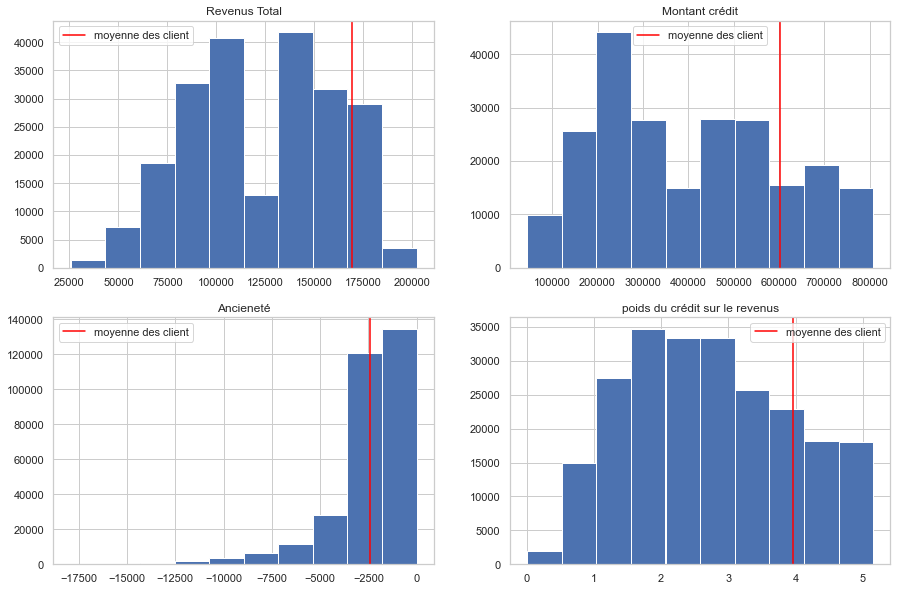

In [21]:
plt.figure(figsize=(15,10))
valMaxi = train["AMT_INCOME_TOTAL"].describe()['75%']
plt.subplot(2, 2, 1)
train.loc[train["AMT_INCOME_TOTAL"]<valMaxi,"AMT_INCOME_TOTAL"].hist()
plt.axvline(trainNondef["AMT_INCOME_TOTAL"].mean(), color='red', label="moyenne des client")
plt.legend()
plt.title("Revenus Total")

valMaxi = train["AMT_CREDIT"].describe()['75%']
plt.subplot(2, 2, 2)
train.loc[train["AMT_CREDIT"]<valMaxi,"AMT_CREDIT"].hist()
plt.axvline(trainNondef["AMT_CREDIT"].mean(), color='red', label="moyenne des client")
plt.legend()
plt.title("Montant crédit")

plt.subplot(2, 2, 3)
valMaxi = train["DAYS_EMPLOYED"].describe()['max']
train.loc[train["DAYS_EMPLOYED"]<valMaxi,"DAYS_EMPLOYED"].hist()
plt.axvline(trainNondef["DAYS_EMPLOYED"].astype('float64').mean(), color='red', label="moyenne des client")
plt.legend()
plt.title("Ancieneté")

plt.subplot(2, 2, 4)
valMaxi = train["credSURrevenu"].describe()['75%']
train.loc[train["credSURrevenu"]<valMaxi,"credSURrevenu"].hist()
plt.axvline(trainNondef["credSURrevenu"].astype('float64').mean(), color='red', label="moyenne des client")
plt.legend()
plt.title("poids du crédit sur le revenus")

In [22]:
trainNondef["credSURrevenu"].astype('float64').mean()

3.9638173388115656

In [23]:
trainNondef["credSURrevenu"].describe()

count    282670.000000
mean               NaN
std           0.000000
min           0.037506
25%           2.000000
50%           3.267578
75%           5.191406
max          49.218750
Name: credSURrevenu, dtype: float64

In [24]:
trainNondef["FL"].describe()

KeyError: 'FL'

In [25]:
trainNondef.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 282670 entries, 1 to 307494
Data columns (total 50 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   SK_ID_CURR                  282670 non-null  int32   
 1   TARGET                      282670 non-null  int8    
 2   NAME_CONTRACT_TYPE          282670 non-null  category
 3   CODE_GENDER                 282670 non-null  category
 4   FLAG_OWN_CAR                282670 non-null  category
 5   FLAG_OWN_REALTY             282670 non-null  category
 6   CNT_CHILDREN                282670 non-null  int8    
 7   AMT_INCOME_TOTAL            282670 non-null  float32 
 8   AMT_CREDIT                  282670 non-null  float32 
 9   AMT_ANNUITY                 282670 non-null  float32 
 10  AMT_GOODS_PRICE             282670 non-null  float32 
 11  NAME_INCOME_TYPE            282670 non-null  category
 12  NAME_EDUCATION_TYPE         282670 non-null  category
 13 

In [27]:
train["NAME_FAMILY_STATUS"].unique()

['Single / not married', 'Married', 'Civil marriage', 'Widow', 'Separated', 'Unknown']
Categories (6, object): ['Single / not married', 'Married', 'Civil marriage', 'Widow', 'Separated', 'Unknown']